In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import preprocessing

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

from lofo import LOFOImportance, Dataset, plot_importance
from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold
from sklearn.metrics import make_scorer

pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

***
## correlation between features

In [3]:
cols_pearson = train[input_cols].corr(method="pearson")
cols_spearman = train[input_cols].corr(method="spearman")

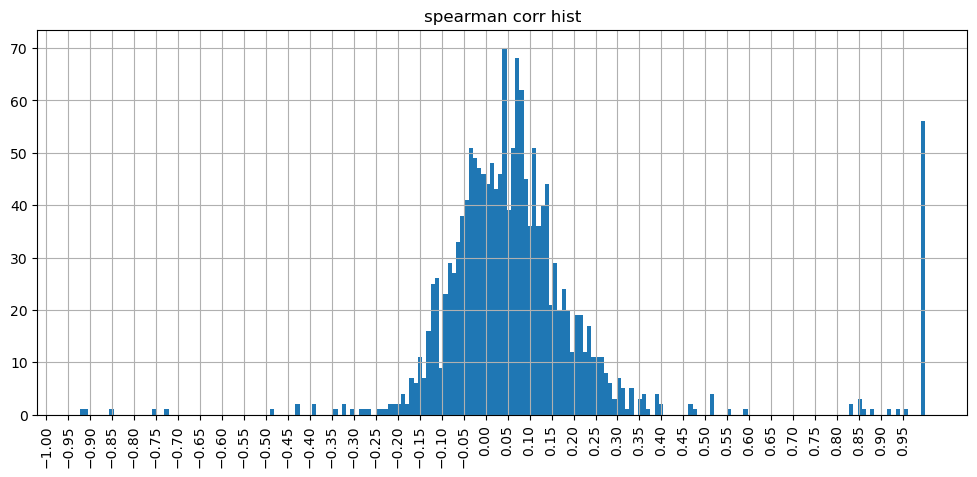

In [4]:
corrs = cols_spearman.values
corrs = corrs[np.triu_indices(corrs.shape[0])]

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(corrs, bins=200)
plt.grid()
x_ticks = np.arange(-1, 1, 0.05)
ax.set_xticks(x_ticks)
plt.xticks(rotation = 90)
plt.title("spearman corr hist")
plt.show()

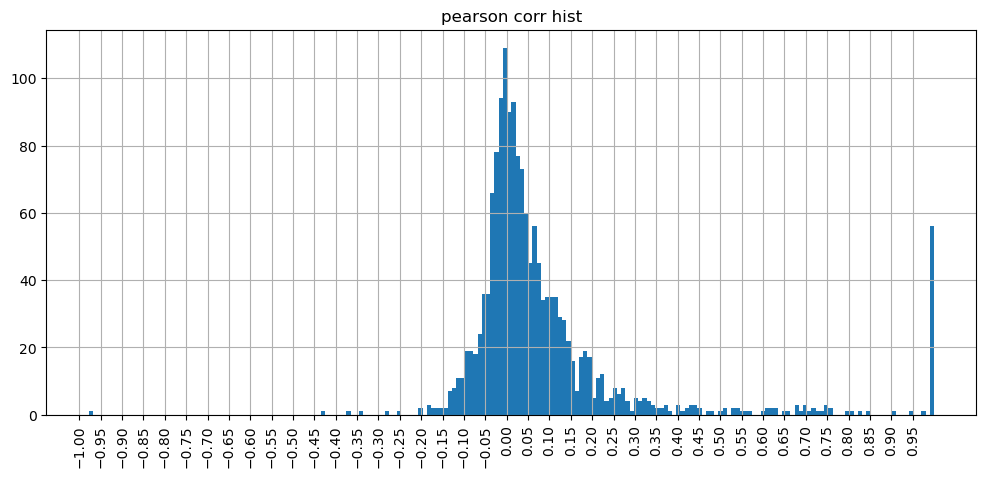

In [5]:
corrs = cols_pearson.values
corrs = corrs[np.triu_indices(corrs.shape[0])]

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(corrs, bins=200)
plt.grid()
x_ticks = np.arange(-1, 1, 0.05)
ax.set_xticks(x_ticks)
plt.xticks(rotation = 90)
plt.title("pearson corr hist")
plt.show()

***
## training

In [6]:
def balanced_logloss_(y_true, y_pred):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_true, y_pred), False 

balanced_logloss_scorer = make_scorer(
    balanced_logloss_, 
    greater_is_better=False
)

In [7]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [8]:
#balance_method = "weight"
balance_method = "bagging"

model_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'max_bin': 63,
    'num_leaves': 7,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,
    'feature_fraction': 0.75,
    'lambda_l1': 0.00020196676966216634,
    'lambda_l2': 2.3627262174517976e-09,
    'min_data_in_leaf': 13,
    'min_gain_to_split': 0.0007626326850799573,
    'num_iterations': 1591,
    'path_smooth': 2.652521741711401e-09
}

if balance_method == "weight":
    model_params["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    model_params["bagging_freq"] = 1
    model_params["pos_bagging_fraction"] = 1
    model_params["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(model_params)

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'max_bin': 63,
 'num_leaves': 7,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'feature_fraction': 0.75,
 'lambda_l1': 0.00020196676966216634,
 'lambda_l2': 2.3627262174517976e-09,
 'min_data_in_leaf': 13,
 'min_gain_to_split': 0.0007626326850799573,
 'num_iterations': 1591,
 'path_smooth': 2.652521741711401e-09,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604}

In [9]:
# base model
lgbm_model = LGBMClassifier(**model_params)
display(lgbm_model)

LGBMClassifier(bagging_freq=1, feature_fraction=0.75, feature_pre_filter=False,
               first_metric_only=False, lambda_l1=0.00020196676966216634,
               lambda_l2=2.3627262174517976e-09, learning_rate=0.005,
               max_bin=63, metric='None', min_data_in_leaf=13,
               min_gain_to_split=0.0007626326850799573,
               neg_bagging_fraction=0.21218074656188604, num_iterations=1591,
               num_leaves=7, objective='binary',
               path_smooth=2.652521741711401e-09, pos_bagging_fraction=1,
               seed=2112, verbosity=-1)

In [10]:
# input dataset
dset = Dataset(
    df = train,
    target = "Class",
    features = input_cols,
    auto_group_threshold = 0.5,
)

Automatically grouped features by correlation:
1 ['AB', 'AM', 'CH']
2 ['AR', 'DI', 'GI']
3 ['AY', 'EP']
4 ['CU', 'DH']
5 ['DU', 'EH', 'EJ', 'FD', 'FL', 'GL']


In [11]:
# cv-split
rmskf = RepeatedMultilabelStratifiedKFold(n_splits=5, n_repeats=10, random_state=2112)
rmskf_split = list(rmskf.split(train, train[["Class","Alpha_B","Alpha_D","Alpha_G"]]))

In [12]:
lofo_imp = LOFOImportance(
    dataset = dset,
    scoring = balanced_logloss_scorer,
    model = lgbm_model,
    fit_params = None,
    cv = rmskf_split,
    n_jobs = 1,
    
)

In [13]:
%%time
importance_df = lofo_imp.get_importance()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  0%|                                                                                                                                                      | 0/45 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  2%|███▏                                                                                                                                          | 1/45 [00:34<24:56, 34.01s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  4%|██████▎                                                                                                                                       | 2/45 [01:08<24:26, 34.11s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  7%|█████████▍                                                                                                                                    | 3/45 [01:42<23:55, 34.17s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  9%|████████████▌                                                                                                                                 | 4/45 [02:16<23:15, 34.05s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 11%|███████████████▊                                                                                                                              | 5/45 [02:50<22:42, 34.05s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 13%|██████████████████▉                                                                                                                           | 6/45 [03:24<22:07, 34.03s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 16%|██████████████████████                                                                                                                        | 7/45 [03:58<21:33, 34.05s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 18%|█████████████████████████▏                                                                                                                    | 8/45 [04:32<20:54, 33.91s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 20%|████████████████████████████▍                                                                                                                 | 9/45 [05:05<20:18, 33.86s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 22%|███████████████████████████████▎                                                                                                             | 10/45 [05:39<19:41, 33.75s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 24%|██████████████████████████████████▍                                                                                                          | 11/45 [06:12<19:06, 33.73s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 27%|█████████████████████████████████████▌                                                                                                       | 12/45 [06:46<18:33, 33.74s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 29%|████████████████████████████████████████▋                                                                                                    | 13/45 [07:20<18:02, 33.83s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 31%|███████████████████████████████████████████▊                                                                                                 | 14/45 [07:54<17:29, 33.84s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 33%|███████████████████████████████████████████████                                                                                              | 15/45 [08:28<16:56, 33.87s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 36%|██████████████████████████████████████████████████▏                                                                                          | 16/45 [09:01<16:17, 33.70s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 38%|█████████████████████████████████████████████████████▎                                                                                       | 17/45 [09:35<15:40, 33.59s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 40%|████████████████████████████████████████████████████████▍                                                                                    | 18/45 [10:08<15:04, 33.48s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 42%|███████████████████████████████████████████████████████████▌                                                                                 | 19/45 [10:41<14:30, 33.47s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 44%|██████████████████████████████████████████████████████████████▋                                                                              | 20/45 [11:15<13:56, 33.47s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 21/45 [11:48<13:22, 33.46s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 49%|████████████████████████████████████████████████████████████████████▉                                                                        | 22/45 [12:22<12:49, 33.47s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 51%|████████████████████████████████████████████████████████████████████████                                                                     | 23/45 [12:55<12:17, 33.51s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 24/45 [13:30<11:48, 33.72s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 25/45 [14:03<11:12, 33.64s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 26/45 [14:37<10:38, 33.63s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 27/45 [15:11<10:06, 33.71s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 28/45 [15:44<09:33, 33.75s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 29/45 [16:19<09:02, 33.92s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 30/45 [16:53<08:30, 34.04s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 31/45 [17:27<07:58, 34.15s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 32/45 [18:02<07:24, 34.21s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 33/45 [18:36<06:50, 34.21s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 34/45 [19:10<06:15, 34.11s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 35/45 [19:44<05:41, 34.14s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 36/45 [20:19<05:08, 34.25s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 37/45 [20:53<04:33, 34.24s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 38/45 [21:27<04:00, 34.32s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 39/45 [22:02<03:26, 34.34s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 40/45 [22:36<02:51, 34.30s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 41/45 [23:11<02:18, 34.53s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 42/45 [23:46<01:43, 34.61s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 43/45 [24:21<01:09, 34.69s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44/45 [24:56<00:34, 34.74s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [25:29<00:00, 33.98s/it]

CPU times: user 3h 25min 51s, sys: 2min 16s, total: 3h 28min 7s
Wall time: 26min 3s


In [14]:
importance_df

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3,val_imp_4,val_imp_5,val_imp_6,val_imp_7,val_imp_8,val_imp_9,val_imp_10,val_imp_11,val_imp_12,val_imp_13,val_imp_14,val_imp_15,val_imp_16,val_imp_17,val_imp_18,val_imp_19,val_imp_20,val_imp_21,val_imp_22,val_imp_23,val_imp_24,val_imp_25,val_imp_26,val_imp_27,val_imp_28,val_imp_29,val_imp_30,val_imp_31,val_imp_32,val_imp_33,val_imp_34,val_imp_35,val_imp_36,val_imp_37,val_imp_38,val_imp_39,val_imp_40,val_imp_41,val_imp_42,val_imp_43,val_imp_44,val_imp_45,val_imp_46,val_imp_47,val_imp_48,val_imp_49
44,DU & EH & EJ & FD & FL & GL,3.213094,1.587934,2.898933e+00,3.628031,4.779801,2.147707,0.954284,1.475392,6.556815,2.867881,1.838222,3.924861,3.624743,4.540521,-0.483729,2.696893,4.095849,1.056980,1.306080,3.755549,4.135966,3.647824,2.185605,5.296941,2.801265,2.950784,0.854940,4.266837,2.862852,2.950784,2.801265,2.636367,4.595488,4.432796,3.652237,3.139889,3.582885,3.309200,0.677247,5.051809,3.755549,4.281071,6.380798,1.814015,0.683952,2.862852,5.588795,6.243479,5.494805,0.613984,3.139889,2.297744
40,AB & AM & CH,0.251954,0.764642,4.440892e-16,0.338623,1.126948,0.000000,-0.784972,0.653040,0.507935,0.170988,1.644704,-0.615661,1.157688,0.446349,-0.483729,0.000000,0.784972,-1.126948,0.169312,0.446349,0.169312,0.000000,-0.338623,0.000000,0.000000,-0.169312,0.341976,0.000000,0.000000,0.653040,0.169312,1.475392,0.822352,0.954284,0.000000,2.354917,0.170988,-0.169312,-2.128432,0.000000,-0.169312,1.160975,1.569944,-0.653040,-0.784972,0.954284,0.000000,0.000000,-0.613984,0.784972,0.784972,0.822352
10,FR,0.249124,0.472287,7.849722e-01,0.169312,0.000000,0.822352,0.000000,0.000000,0.954284,0.784972,0.822352,0.169312,0.654684,0.277037,0.991663,0.170988,0.000000,-0.170988,0.000000,-0.169312,0.169312,0.000000,0.169312,0.000000,0.000000,0.000000,0.000000,0.784972,0.784972,-0.169312,0.507935,1.160975,0.000000,0.000000,0.169312,-0.169312,0.000000,0.169312,-0.822352,0.000000,0.000000,0.338623,1.398956,0.338623,0.000000,0.000000,0.000000,0.000000,0.784972,0.000000,1.400633,-0.822352
17,BQ,0.202842,0.735042,1.709880e-01,-0.822352,1.126948,0.000000,0.784972,-0.507935,1.123595,0.955960,0.338623,0.169312,0.167668,0.446349,0.822352,0.341976,0.000000,0.170988,-1.475392,0.784972,-1.644704,1.400633,0.954284,0.169312,-0.277037,0.000000,0.170988,0.000000,0.954284,-0.338623,0.507935,1.644704,0.000000,-0.169312,-0.314417,1.400633,0.512964,0.169312,-1.306080,-0.955960,0.169312,0.991663,1.126948,0.169312,1.126948,0.000000,0.000000,0.000000,-0.885992,0.341976,0.446349,-0.822352
16,DL,0.187505,0.617899,7.849722e-01,-0.653040,0.170988,0.167668,0.000000,0.000000,0.954284,1.740932,0.169312,0.000000,0.000000,0.000000,1.814015,0.000000,0.000000,-0.170988,0.000000,0.000000,0.000000,0.000000,0.000000,0.169312,0.169312,0.000000,0.170988,0.613984,0.954284,-0.169312,0.169312,0.000000,0.822352,0.000000,0.822352,-0.169312,0.170988,0.000000,-2.636367,0.000000,-0.169312,0.169312,0.784972,0.338623,0.784972,0.784972,0.000000,0.000000,0.784972,0.000000,-0.169312,0.000000
26,BC,0.134610,0.497485,7.849722e-01,0.000000,-0.170988,0.822352,0.000000,0.000000,0.954284,-0.955960,0.822352,0.169312,0.822352,-1.123595,0.822352,0.000000,0.000000,0.000000,-0.991663,0.000000,-0.653040,0.000000,0.000000,0.000000,0.169312,0.653040,0.000000,0.784972,0.784972,-0.169312,0.169312,0.000000,0.991663,0.000000,0.000000,0.000000,0.170988,-0.338623,-0.653040,0.000000,0.000000,0.338623,0.784972,0.338623,0.784972,0.784972,0.000000,-0.167668,0.000000,0.000000,0.000000,0.000000
41,AR & DI & GI,0.117219,0.561236,7.849722e-01,-1.160975,-0.170988,0.000000,0.784972,0.000000,1.123595,-0.170988,0.000000,0.169312,-0.167668,-0.169312,0.822352,0.170988,0.000000,0.000000,0.000000,0.000000,-0.653040,0.000000,0.954284,-0.822352,0.169312,0.822352,0.170988,0.000000,0.954284,0.000000,0.338623,0.653040,0.000000,0.000000,0.991663,0.000000,0.341976,-0.784972,0.169312,-0.955960,-0.169312,-0.653040,1.569944,0.169312,0.784972,0.784972,0.000000,0.000000,0.00000

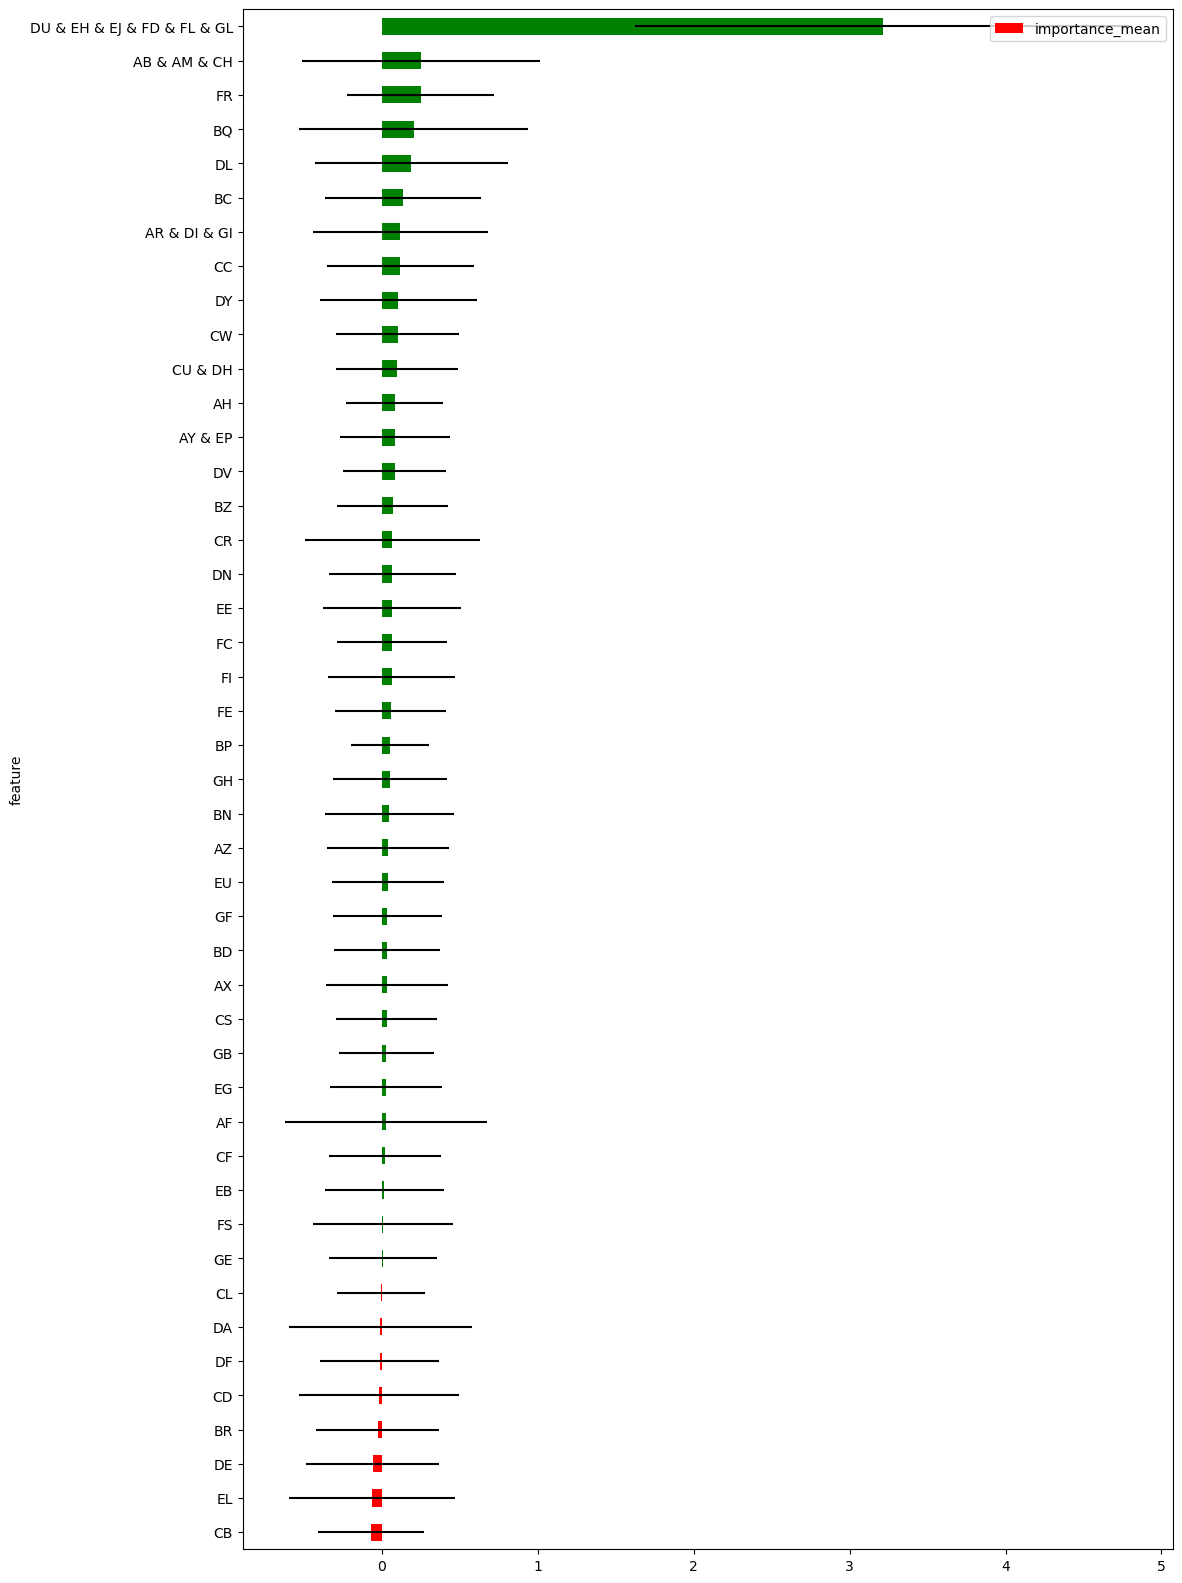

In [15]:
# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

In [21]:
importance_df.query("importance_mean < - 0.01").feature.values.tolist()

['DA', 'DF', 'CD', 'BR', 'DE', 'EL', 'CB']

***